<a href="https://colab.research.google.com/github/jurados/AstroinformaticProject/blob/main/kbmod_stamps_access_w_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# KBMOD Coadd Stamps

## README

The following data was generated for use as part of the [KBMOD](https://github.com/dirac-institute/kbmod) project, for the purpose of creating a machine learning model to filter out false positve results from the KBMOD search. The data set is divided into two sets of data, the true positive and false positive, with each set also divided into the training, validation, and test sets for ML purposes.

### True Positive

This dataset was generated based on the synthetic objects inserted into the DEEP data by Pedro Bernardinelli, and then cutout from the survey dataset by Steven Stetzler. The original stamp cutouts are available on hyak at `/gscratch/dirac/DEEP/collab/fakes_cutouts/data/*/npy` (the `*` being the id of the fake object in DEEP).

### False Positive

This dataset was generated by running KBMOD on the DEEP data, but setting the set of serach angles to be roughly perpendicular to the ecliptic. This allows us to semi-safely assume that any search results are not real or inserted objects (i.e., while some real or synthetic objects may have been included in this set, the ratio to bad results is small enough to not be of concern for machine learning purposes).

### Data Transformation

Each source observation in the above set was ran through a series of random transformations, to enlarge the dataset and to capture all possible features of both sets. Those transformations were:
- select a random subset of the total set to coadd, with a minimum number of observations set to 25
    - so if the N number of observations is > 25 then the set of stamps used in coadding is of length [25,N]
- potentially offset the center pixel of each stamp by one in either direction, for both the X and Y in pixel space
    - so the set x_offset = [-1, 0, 1] and y_offset = [-1, 0, 1], creating nine potential offset states around the "actual" center of the object/results.
- potentially mirror around both the x and y axis
- potentially rotate 90 degrees around the center N times, where N is [0-3]

### Data Format

The data arrays are stored as numpy `.npy` files, and can be loaded with `x = np.load(PATH)`.

The shape of the data is `(N, 3, 21, 21)`, where N is the number of individual stamps in each set. The second dimmension corresponds to the type of coadd performed.
- index 0 = median coadd stamp
- index 1 = mean coadd stamp
- index 2 = sum coadd stamp.
Side note: the true positive stamp files also have an index 3, which corresponds to the recently added variance weighted coadd stamps. However, we found some discrepancies in those stamps and decided not to generate them for the false positive stamp. You can filter out this fourth column from the true positive set by slicing the array like [:,:3,:,:].

Each coadd stamp has the shape (21,21).

## Data

Here are the preloaded data sets. If you want to generate your own train, test, and validation sets, you can load in the `true_positive_stamps_full.npy` and `false_positive_stamps_full.npy` files.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/(POSGRADO) Universidad de Chile/ELECTIVE - Astroinformatic/Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/(POSGRADO) Universidad de Chile/ELECTIVE - Astroinformatic/Project


In [3]:
data_dir = "./kbmod_ml_stamps/"

# TRUE POSITVE PATHS
true_pos_full  = os.path.join(data_dir, "true_positive_stamps_full.npy")
true_pos_train = os.path.join(data_dir, "true_train_stamps.npy")
true_pos_valid = os.path.join(data_dir, "true_valid_stamps.npy")
true_pos_test  = os.path.join(data_dir, "true_test_stamps.npy")

# FALSE POSITVE PATHS
false_pos_full  = os.path.join(data_dir, "false_positive_stamps_full.npy")
false_pos_train = os.path.join(data_dir, "false_train_stamps.npy")
false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
false_pos_test  = os.path.join(data_dir, "false_test_stamps.npy")

In [4]:
true_train = np.load(true_pos_train)[:,:3,:,:] # this indexing isn't strictly needed if you're just grabbing one of the other coadd type columns, see below cell.
true_test  = np.load(true_pos_test)[:,:3,:,:]

false_train = np.load(false_pos_train)
true_train.shape, false_train.shape

((129010, 3, 21, 21), (110530, 3, 21, 21))

In [5]:
true_train_median  = true_train[:,0,:,:]
false_train_median = false_train[:,0,:,:]

true_train_median.shape, false_train_median.shape

((129010, 21, 21), (110530, 21, 21))

## Visualization

If you want to visualize what certain stamps look like, you can use `plt.imshow` and pass in the desired row.

Side note on visualizing the true positive stamps: we specifically weakened the signal on some of the observations to simulate a wider range of data. Visualizing some of the stamps might seem like mostly random noise, but I do promise there is signal there. Some of the time the PSF isn't visible in the median stamp but is seen in the mean or sum, or vice versa. I'm still messing around with the dataset so if we're running into too much low-SNR contimination in this set, we can raise the minimum observations in the selection algorithm and rerun everything, it only takes about 20 minutes to do :

In [6]:
def plot_true_false(true, false):
    '''Plot a random set of true and false images'''
    fig_0,ax_0 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    fig_1,ax_1 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    ax_0 = ax_0.reshape(-1)
    ax_1 = ax_1.reshape(-1)
    true_int_list = np.random.choice(len(true),10,replace=False)
    false_int_list = np.random.choice(len(false),10,replace=False)
    for i, ax in enumerate(ax_0):
        ax.imshow(true[true_int_list[i]])
    for i, ax in enumerate(ax_1):
        ax.imshow(false[false_int_list[i]])
    fig_0.suptitle('True',fontsize=16)
    fig_1.suptitle('False',fontsize=16)
    fig_0.tight_layout()
    fig_1.tight_layout()

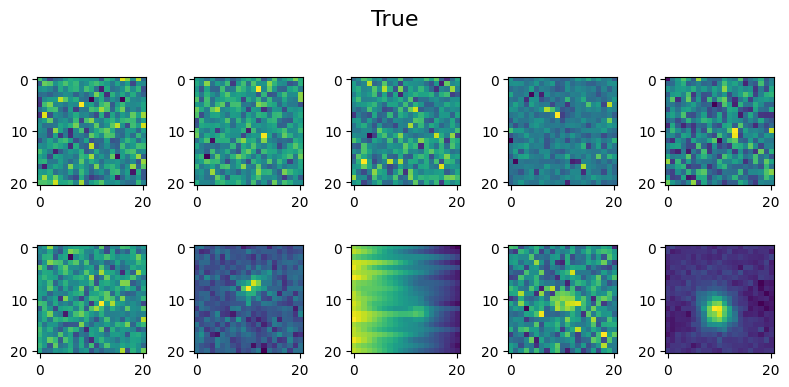

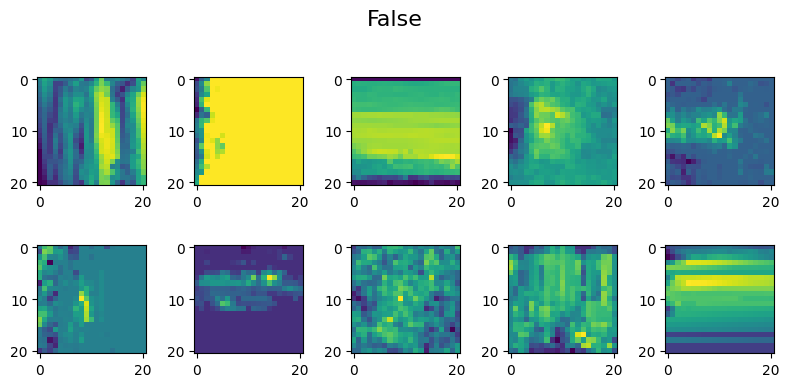

In [7]:
plot_true_false(true_train[:,0,:,:], false_train[:,0,:,:])

## Training

I've included a simple model here as jumping off point. Go wild!

In [8]:
false_pos_valid = os.path.join(data_dir, "false_valid_stamps.npy")
_a = np.load(false_pos_valid)

In [9]:
# combine data
from tensorflow.keras.utils import to_categorical
def stack_data(f, t):
    input_stamps = np.vstack([f, t])
    stamp_class = np.zeros(len(f) + len(t))
    stamp_class[len(f):] = 1

    rand_state = np.random.RandomState(32)
    idx = rand_state.permutation(len(input_stamps))
    input_stamps = input_stamps[idx]
    stamp_class = stamp_class[idx]
    stamp_class = to_categorical(stamp_class)
    #stamp_class = stamp_class.astype(int)
    return input_stamps, stamp_class

The normalization technique employed will be

$$I_{\text{new}} = \frac{I - I_{\min}}{I_{\max} - I_{\min}}$$

In [10]:
def normalization(array, new_max: float = 1, new_min:float = 0):
    new_array = (array - array.min()) * (new_max - new_min) / (array.max() - array.min()) + new_min
    return new_array

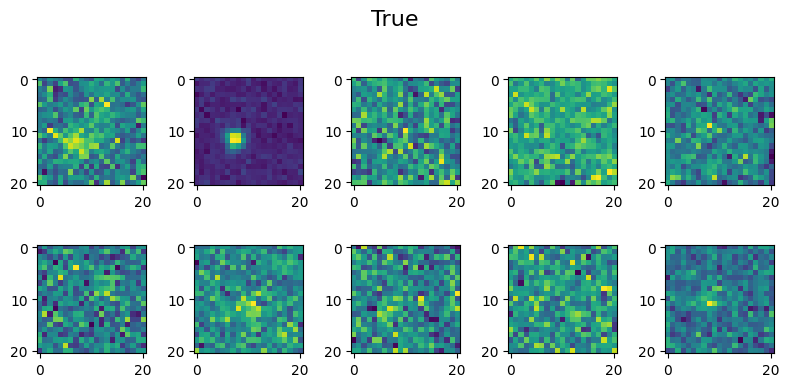

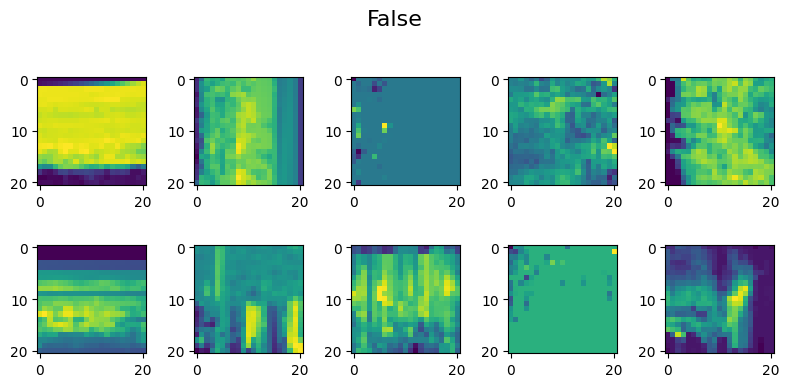

In [11]:
false_train_median, true_train_median = normalization(false_train_median), normalization(true_train_median)
plot_true_false(true_train_median, false_train_median)

In [12]:
true_valid_median  = normalization(np.load(true_pos_valid)[:,0,:,:])
false_valid_median = normalization(np.load(false_pos_valid)[:,0,:,:])

true_test_median  = normalization(np.load(true_pos_test)[:,0,:,:])
false_test_median = normalization(np.load(false_pos_test)[:,0,:,:])

train_data, train_class = stack_data(false_train_median, true_train_median)
val_data, val_class     = stack_data(false_valid_median, true_valid_median)
test_data, test_class   = stack_data(false_test_median, true_test_median)

# Reshape [Channel, Heigh, Width]
train_data = train_data.reshape(-1,1,21,21)
val_data   = val_data.reshape(-1,1,21,21)
test_data  = test_data.reshape(-1,1,21,21)

In [13]:
print('Train_data shape:',train_data.shape, 'Train_class shape:',train_class.shape)
print('Val_data shape:',val_data.shape,'Val_class shape:',val_class.shape)
print('Test_data shape:',test_data.shape,'Test_class shape:',test_class.shape)

Train_data shape: (239540, 1, 21, 21) Train_class shape: (239540, 2)
Val_data shape: (68440, 1, 21, 21) Val_class shape: (68440, 2)
Test_data shape: (34220, 1, 21, 21) Test_class shape: (34220, 2)


In [14]:
%%capture
try:
    import lightning as L
except:
    !pip install lightning

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/")

from torchvision import transforms
from torchsummary import summary
from torchmetrics.classification import Accuracy, Recall

import lightning as L

from tqdm.auto import tqdm

device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
# Defining the transformations
trasforms_90  = transforms.RandomRotation(degrees=90)
trasforms_180 = transforms.RandomRotation(degrees=180)
trasforms_270 = transforms.RandomRotation(degrees=270)

In [17]:
initial_settings = {
    'batch_size': 512,
    'max_epochs': 10,
    'learning_rate': 1e-3,
}

[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

Shape:
- Input:  $(N,C_{in},H_{in}, W_{in})$ or $(C_{in},H_{in}, W_{in})$
- Output: $(N,C_{out},H_{out}, W_{out})$ or $(C_{out},H_{out}, W_{out})$

Parameters:
- `in_channels`
- `out_channels`
- `kernel_size`
- `stride`: Default value is 1.
- `padding`: Default value is 0.
- `dilation`: Default value is 1.
- `groups`: controls the connections between inputs and outputs.
- `bias`: If `True`, adds a learnable bias to the output.
- `padding_mode`


$$ H_{out}=\left[\frac{H_{in}+2 \times \text{padding}[0]-\text{dilation}[0] \times (\text{kernel_size}[0]- 1)- 1}{\text{stride}[0]} +1 \right]
$$
$$ W_{out}=\left[\frac{W_{in}+2 \times \text{padding}[1]-\text{dilation}[1] \times (\text{kernel_size}[1]- 1)- 1}{\text{stride}[0]} +1 \right]
$$

Parameters:
- `kernel_size`
- `stride`: Default value is `kernel_size`.
- `padding`
- `dilation`
- `return_indices`: If `True`, will return te max indices along with the outputs. Useful for `torch.nn.MaxUnpool2d` later.
- `ceil_mode`: when `True`, will use _ceil_ instead of _floor_ to compute the output shape.


[`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

Shape:
- Input:  $(N,C,H_{in}, W_{in})$ or $(C,H_{in}, W_{in})$
- Output: $(N,C,H_{out}, W_{out})$ or $(C,H_{out}, W_{out})$

Parameters:
- `kernel_size`
- `stride`: Default value is `kernel_size`.
- `padding`
- `dilation`
- `return_indices`: If `True`, will return te max indices along with the outputs. Useful for `torch.nn.MaxUnpool2d` later.
- `ceil_mode`: when `True`, will use _ceil_ instead of _floor_ to compute the output shape.

$$ H_{out}=\left[\frac{H_{in}+2 \times \text{padding}[0]-\text{dilation}[0] \times (\text{kernel_size}[0]- 1)- 1}{\text{stride}[0]} +1 \right]
$$
$$ W_{out}=\left[\frac{W_{in}+2 \times \text{padding}[1]-\text{dilation}[1] \times (\text{kernel_size}[1]- 1)- 1}{\text{stride}[0]} +1 \right]
$$

### Model V0: Basic

In [139]:
class Basic(L.LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        #self.save_hyperparameters()
        self.model_layers = nn.Sequential(
            # Input (Cin=1, Hin=21, Win=21, kenel_size=3, stride=1, padding=0, dilation=1)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            # Output (Cout=8, Hin=18, Win=18)
            nn.ReLU(),
            # Output (Cout=8, Hin=18, Win=18)
            nn.BatchNorm2d(num_features=8),
            # Output (Cout=8, Hin=18, Win=18)
            nn.MaxPool2d(kernel_size=2),
            # Output (Cout=8, Hin=9, Win=9)
            nn.Dropout(p=0.25),
            # Output (Cout=8, Hin=9, Win=9)
            nn.Flatten(),
            # Output (8*9*9)
            nn.Linear(in_features=8*9*9, out_features=64),
        )
        self.activation = nn.Sigmoid() if n_classes == 1 else nn.Softmax(dim=1)
        self.fc_out = nn.Linear(in_features=64, out_features=1024)

    def forward(self, x):
        # print(x.shape) # [Batch, Heigh, Width, Channel]
        x = x.view(x.size(0), 1, 21, 21)
        x = self.model_layers(x)
        #x = self.fc_out(x)
        #x = self.activation(x)
        return x

model = Basic(n_classes=2).to(device) # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]              80
              ReLU-2            [-1, 8, 19, 19]               0
       BatchNorm2d-3            [-1, 8, 19, 19]              16
         MaxPool2d-4              [-1, 8, 9, 9]               0
           Dropout-5              [-1, 8, 9, 9]               0
           Flatten-6                  [-1, 648]               0
            Linear-7                   [-1, 64]          41,536
Total params: 41,632
Trainable params: 41,632
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.16
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


### Model V1: ResNet-56

In [19]:
class ResidualBlock(nn.Module):
    """

    change_size: flag to indicate if activations are within normal residual blocks
    """

    def __init__(self, in_channel, out_channel, stride, change_size=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=stride)
        self.bn1   = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, stride=1)
        self.bn2   = nn.BatchNorm2d(out_channel)
        self.change_size = change_size
        # for changing activation map sizes
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, out_channel,
                                            kernel_size=1, stride=stride),
                                nn.BatchNorm2d(out_channel)
            )

    def forward(self,x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity

        return F.relu(y)


class ResNet56(nn.Module):
    """RestNet56
    """
    def __init__(self, n=9, num_classes=2):
        super().__init__()
        self.conv1  = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, out_channel=16, stride=1, change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, out_channel=32, stride=2, change_size=True)
        self.block3 = self.create_block(n=9, in_channel=32, out_channel=64, stride=2, change_size=True)
        self.fc     = nn.Linear(64, num_classes)
        self.activation = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [ResidualBlock(in_channel, out_channel, stride, change_size)]
        for i in range(n-1):
            block.append(ResidualBlock(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)

    def forward(self, x):
        x = x.view(x.size(0), 1, 21, 21)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block1(y)
        y = self.block2(y)
        y = self.block3(y)
        y = F.adaptive_avg_pool2d(input=y, output_size=1)
        #y = self.fc(y.view(y.size(0), -1))
        #y = self.activation(y)
        return y

model = ResNet56().to(device)   # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 21, 21]             160
       BatchNorm2d-2           [-1, 16, 21, 21]              32
            Conv2d-3           [-1, 16, 21, 21]           2,320
       BatchNorm2d-4           [-1, 16, 21, 21]              32
            Conv2d-5           [-1, 16, 21, 21]           2,320
       BatchNorm2d-6           [-1, 16, 21, 21]              32
     ResidualBlock-7           [-1, 16, 21, 21]               0
            Conv2d-8           [-1, 16, 21, 21]           2,320
       BatchNorm2d-9           [-1, 16, 21, 21]              32
           Conv2d-10           [-1, 16, 21, 21]           2,320
      BatchNorm2d-11           [-1, 16, 21, 21]              32
    ResidualBlock-12           [-1, 16, 21, 21]               0
           Conv2d-13           [-1, 16, 21, 21]           2,320
      BatchNorm2d-14           [-1, 16,

### Model V2: ResNet-50

Here, model_parameters[‘resnet50’] = ([64,128,256,512],[3,4,6,3],4,True) represents the parameters for resnet-50 where

[64,128,256,512] -> channels in each intermediate block
[3,4,6,3] -> # repeatition for Bottlenecks in each block
4 -> expansion_factor. Note that 64 turns to 256, 128 to 512. All the resnet layers use the same expansion factor.
True -> create Bottleneck layer status. True only for ResNet 50+


In [20]:
# This model is upload
import torchvision

class ResNet50(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet50 = torchvision.models.resnet50(weights="DEFAULT")

        # Dont change the parameters
        # Keep without change the parameters
        for param in self.resnet50.parameters():
            param.requires_grad = False

        self.resnet50.conv1 = nn.Conv2d(in_channels=1, out_channels=self.resnet50.conv1.out_channels,
                                        kernel_size=self.resnet50.conv1.kernel_size, stride=self.resnet50.conv1.stride,
                                        padding=self.resnet50.conv1.padding, bias=False) # change input channels to 21
        self.resnet50.fc = nn.Linear(in_features=self.resnet50.fc.in_features, out_features=num_classes)
        self.activation = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)


    def forward(self, x):
        x = x.view(x.size(0), 1, 21, 21)
        y = self.resnet50(x)
        #y = self.activation(y)
        return y

model = ResNet50(num_classes=2).to(device=device)
summary(model, (1, 21, 21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 11, 11]           3,136
       BatchNorm2d-2           [-1, 64, 11, 11]             128
              ReLU-3           [-1, 64, 11, 11]               0
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 6, 6]           4,096
       BatchNorm2d-6             [-1, 64, 6, 6]             128
              ReLU-7             [-1, 64, 6, 6]               0
            Conv2d-8             [-1, 64, 6, 6]          36,864
       BatchNorm2d-9             [-1, 64, 6, 6]             128
             ReLU-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 256, 6, 6]          16,384
      BatchNorm2d-12            [-1, 256, 6, 6]             512
           Conv2d-13            [-1, 256, 6, 6]          16,384
      BatchNorm2d-14            [-1, 25

In [21]:
x = torch.randn(5, 1, 21, 21).to(device=device)  # Batch de 5 imágenes
y_hat = model(x)
print(y_hat)

tensor([[ 0.0735, -0.2350],
        [ 0.0637, -0.0394],
        [ 0.0116,  0.0415],
        [-0.2317, -0.0758],
        [-0.2945, -0.1831]], grad_fn=<AddmmBackward0>)


In [22]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion, is_Bottleneck):
        super(Bottleneck, self).__init__()
        self.expansion = expansion
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_Bottleneck = is_Bottleneck

        if self.in_channels == self.out_channels*self.expansion:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(self.in_channels, self.out_channels*self.expansion, kernel_size=1, stride=stride))
            # Only Conv -> BN and no Relu
            # projection_layer.append(nn.ReLu())
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

        # is_Bottleneck = True for all ResNet
        if self.is_Bottleneck:
            # Bottleneck
            # 1x1
            self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1)
            self.bn1 = nn.BatchNorm2d(self.out_channels)
            # 3x3
            self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=stride, padding=1)
            self.bn2 = nn.BatchNorm2d(self.out_channels)
            # 1x1
            self.conv3 = nn.Conv2d(self.out_channels, self.out_channels  * self.expansion, kernel_size=1, stride=1)
            self.bn3 = nn.BatchNorm2d(self.out_channels*self.expansion)

    def forward(self, x):
        identity = x
        if self.is_Bottleneck:
            # conv1x1 -> BN -> ReLU
            x = self.relu(self.bn1(self.conv1(x)))
            # conv3x3 -> BN -> ReLU
            x = self.relu(self.bn2(self.conv2(x)))
            # conv1x1 -> BN
            x = self.bn3(self.conv3(x))

        if self.identity:
            x += identity
        else:
            x += self.projection(identity)
        x = self.relu(x)
        return x

class ModelV2(nn.Module):
    """
    ResNet-50 model
    """

    def __init__(self, in_channels, num_classes):
        super(ModelV2, self).__init__()

        self.channels_list = [64,128,256,512]
        self.repeatition_list = [3,4,6,3]
        self.expansion = 4
        self.is_Bottleneck = True

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.block1 = self._make_blocks(64, self.channels_list[0], 3, stride=1, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block2 = self._make_blocks(self.channels_list[0]*self.expansion, self.channels_list[1], self.repeatition_list[1], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block3 = self._make_blocks(self.channels_list[1]*self.expansion, self.channels_list[2], self.repeatition_list[2], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)
        self.block4 = self._make_blocks(self.channels_list[2]*self.expansion, self.channels_list[3], self.repeatition_list[3], stride=2, expansion=self.expansion, is_Bottleneck=self.is_Bottleneck)

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3]*self.expansion, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), 1, 21, 21)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        return x

    def _make_blocks(self, in_channels, out_channels, num_repeat, stride, expansion, is_Bottleneck):
        layers = [Bottleneck(in_channels, out_channels, stride, expansion, is_Bottleneck)]
        for i in range(1, num_repeat):
            layers.append(Bottleneck(out_channels*expansion, out_channels, 1, expansion, is_Bottleneck))
        return nn.Sequential(*layers)

model = ModelV2(in_channels=1, num_classes=2).to(device)   # Move the model to the GPU
summary(model, (21, 21, 1))  # Now call summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 11, 11]           3,200
       BatchNorm2d-2           [-1, 64, 11, 11]             128
              ReLU-3           [-1, 64, 11, 11]               0
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 6, 6]           4,160
       BatchNorm2d-6             [-1, 64, 6, 6]             128
              ReLU-7             [-1, 64, 6, 6]               0
            Conv2d-8             [-1, 64, 6, 6]          36,928
       BatchNorm2d-9             [-1, 64, 6, 6]             128
             ReLU-10             [-1, 64, 6, 6]               0
           Conv2d-11            [-1, 256, 6, 6]          16,640
      BatchNorm2d-12            [-1, 256, 6, 6]             512
           Conv2d-13            [-1, 256, 6, 6]          16,640
             ReLU-14            [-1, 25

In [266]:
from typing_extensions import Self
class StampClassifier(L.LightningModule):
    def __init__(self, num_classes, model: str):
        super().__init__()

        if model == 'basic':
            self.model = Basic(num_classes)
        elif model == 'resnet56':
            self.model = ResNet56(num_classes)
        elif model == 'resnet50':
            self.model  = ResNet50(num_classes)

        self.fc = nn.Linear(in_features=64, out_features=num_classes)

        # Metrics
        self.train_acc = Accuracy(task="multilabel", num_labels=num_classes)
        self.val_acc   = Accuracy(task="multilabel", num_labels=num_classes)
        self.test_acc  = Accuracy(task="multilabel", num_labels=num_classes)

        self.train_recall = Recall(task="multilabel", num_labels=num_classes)
        self.val_recall   = Recall(task="multilabel", num_labels=num_classes)
        self.test_recall  = Recall(task="multilabel", num_labels=num_classes)

    def forward(self, x):

        #print('x hola', x.shape)
        x = x.view(x.shape[0], 1, 21, 21)
        y_hat = self.model(x)
        #y_hat = nn.Flatten()(y_hat)
        #features.append(y_hat)
        #print(len(features))
        #out = torch.cat(features, dim=1)
        #print('Out catenation:',out.shape)
        #out = self.fc(out)
        #print('Final out', out.shape)
        #print(out)
        #return out
        return y_hat

    def training_step(self, batch, batch_idx):
        print(len(batch))
        print([[x[:, 0] for x in b] for b in batch][0])
        x_views = [torch.stack([x[:, 0] for x in b]) for b in batch]  # Tensor de imágenes por batch
        y = [torch.stack([x[1] for x in b]) for b in batch]
        print(x_views[0].shape)
        print(y[0].shape)
        #batch = list(zip(*batch)
        #y = [[x[1] for x in bat] for bat in batch]

        #print(x_views)
        # Convertir a tensores usando torch.tensor y torch.stack
        x_views = torch.stack([torch.tensor(x, dtype=torch.float32) for x in x_views])
        y = torch.stack([torch.tensor(x, dtype=torch.float32) for x in y])

        #print(x_views[0])
        #print(y[0])
        all_features = []
        for x_view in x_views:
            y_hat = self(x_view)
            y_hat = nn.Flatten()(y_hat)
            print('y:', y[:5])
            print('y_hat:',y_hat[:5])
            all_features.append(y_hat)

        combined_features = torch.cat(all_features, dim=1)
        y_hat = self.fc(combined_features)

        loss = self.loss_function()(y_hat, y)

        # Log metrics
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_accuracy", self.train_acc(y_hat, y), on_epoch=True, prog_bar=True)
        self.log("train_recall", self.train_recall(y_hat, y), on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        x_views, y = zip(batch)

        y = y[0]  # Verificamos que todas las etiquetas son iguales
        all_features = []
        for x_view in x_views:
            x_view = x_view.view(x_view.size(0), 1, 21, 21)
            y_hat = self(x_view)
            y_hat = nn.Flatten()(y_hat)
            all_features.append(y_hat)

        combined_features = torch.cat(all_features, dim=1)
        y_hat = self.fc(combined_features)

        loss = self.loss_function()(y_hat, y)
        loss = loss.float()
        # Log metrics
        self.log(f"val_loss", loss.item(), on_epoch=True)
        self.log(f"val_accuracy", self.val_acc(y_hat, y), on_epoch=True, prog_bar=True)
        self.log(f"val_recall", self.val_recall(y_hat, y), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x_view, y = batch
        #y_hat = self.model(x_view)
        y_hat = self(x_view)
        loss = self.loss_function()(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)
        self.log("test_accuracy", self.test_acc(y_hat, y), on_epoch=True)
        self.log("test_recall", self.test_recall(y_hat, y), on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=initial_settings['learning_rate'])
        return optimizer

    def loss_function(self):
        return nn.CrossEntropyLoss()

### Training and Validation

In [96]:
class StampsDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform = None):
        self.data      = data
        self.labels    = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label  = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

def created_augmented_dataset(data, labels, batch_size, shuffle=True):

    # Define the transforms
    transform_dict = {
        'original': transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: normalization(x)), transforms.Lambda(lambda x: x.view(-1, 21,21))]),
        'rotated_90': transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(90), transforms.Lambda(lambda x: normalization(x)), transforms.Lambda(lambda x: x.view(-1, 21,21))]),
        'rotated_180': transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(180), transforms.Lambda(lambda x: normalization(x)), transforms.Lambda(lambda x: x.view(-1, 21,21))]),
        'rotated_270': transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(270), transforms.Lambda(lambda x: normalization(x)), transforms.Lambda(lambda x: x.view(-1, 21,21))]),
    }

    # Crete dataset
    dataset = [
        StampsDataset(data, labels, transform=transform)
        for transform in transform_dict.values()
    ]

    dataloader = [
        DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        for dataset in dataset
    ]

    # Combine all dataset
    #combined_dataset = torch.utils.data.ConcatDataset(dataset)

    # Create the DataLoader for the ddataset
    #combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size)

    return dataset, dataloader

n = 1000

train_dataset, train_dataloader = created_augmented_dataset(train_data[:n], train_class[:n], batch_size=initial_settings['batch_size'])
val_dataset, val_dataloader     = created_augmented_dataset(val_data[:n], val_class[:n], batch_size=initial_settings['batch_size'], shuffle=False)
test_dataset, test_dataloader   = created_augmented_dataset(test_data[:n], test_class[:n], batch_size=initial_settings['batch_size'], shuffle=False)

In [97]:
train_dataset[0].__len__(), train_dataset[1].__len__(), train_dataset[2].__len__(), train_dataset[3].__len__()

(1000, 1000, 1000, 1000)

In [49]:
val_dataloader[0].__len__(), train_dataloader[1].__len__(), train_dataloader[2].__len__(), train_dataloader[3].__len__()

(2, 2, 2, 2)

In [50]:
x, y = next(iter(train_dataloader[0]))
x.shape, x[0].max(), y.shape, y[:5]

(torch.Size([512, 1, 21, 21]),
 tensor(1.),
 torch.Size([512, 2]),
 tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.]], dtype=torch.float64))

In [51]:
x, y = next(iter(val_dataloader[0]))
x.shape, x[0].max(), y.shape, y[:10]

(torch.Size([512, 1, 21, 21]),
 tensor(1.),
 torch.Size([512, 2]),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.]], dtype=torch.float64))

In [175]:
from lightning.pytorch.callbacks import Callback

class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            "train_loss": [],
            "train_accuracy": [],
            "train_recall": [],
            "val_loss": [],
            "val_accuracy": [],
            "val_recall": [],
            "test_loss": [],
            "test_accuracy": [],
            "test_recall": [],
        }

    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve and save training metrics
        train_loss = trainer.callback_metrics.get("train_loss")
        train_accuracy = trainer.callback_metrics.get("train_accuracy")

        self.metrics["train_loss"].append(train_loss.item())
        self.metrics["train_accuracy"].append(train_accuracy.item())
        self.metrics["train_recall"].append(trainer.callback_metrics.get("train_recall").item())

    """
    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve and save validation metrics
       0 val_loss = trainer.callback_metrics.get("val_loss")
        val_accuracy = trainer.callback_metrics.get("val_accuracy")
        if val_loss == None: val_loss = 0
        self.metrics["val_loss"].append(val_loss.item())
        self.metrics["val_accuracy"].append(val_accuracy.item())
        self.metrics["val_recall"].append(trainer.callback_metrics.get("val_recall").item())

    def on_test_epoch_end(self, trainer, pl_module):
        # Retrieve and save test metrics
        test_loss = trainer.callback_metrics.get("test_loss")
        test_accuracy = trainer.callback_metrics.get("test_accuracy")
        self.metrics["test_loss"].append(test_loss.item())
        self.metrics["test_accuracy"].append(test_accuracy.item())
        self.metrics["test_recall"].append(trainer.callback_metrics.get("test_recall").item())
    """
    def get_metrics(self):
        """Returns the metrics dictionary for plotting."""
        return self.metrics

In [213]:
batches = [  [[[0,0], [0]], [[1,1], [1]]],
             [[[2,2], [2]], [[3,3], [3]]],
             [[[4,4], [4]], [[5,5], [5]]],
             [[[6,6], [6]], [[7,7], [7]]] ]

X = [[x[0] for x in batch] for batch in batches]
y = [[x[1] for x in batch] for batch in batches]

print(X), print(y)

[[[0, 0], [1, 1]], [[2, 2], [3, 3]], [[4, 4], [5, 5]], [[6, 6], [7, 7]]]
[[[0], [1]], [[2], [3]], [[4], [5]], [[6], [7]]]


(None, None)

In [267]:
models = ['basic']#, 'resnet56', 'resnet50']
#models = ['resnet56']#, 'resnet50']
results_metrics = {}
results_predictions = {}

for model in models:
    classifier = StampClassifier(num_classes=2, model=model)
    metrics_callback = MetricsCallback()

    trainer = L.Trainer(max_epochs=initial_settings['max_epochs'],
                        callbacks=[metrics_callback],)
                        #reload_dataloaders_every_n_e0pochs=True)
    #f00or i in range(4):
    #    print(val_dataloader[i].__len__())
    #    test = trainer.fit(classifier, train_dataloader[i], val_dataloader[i])
    #    print("Test", test)
    #    break
    trainer.fit(classifier, train_dataloader, val_dataloader)

    """
    # Retrieve metrics
    metrics = metrics_callback.get_metrics()

    # Store the results
    results_metrics[model] = metrics

    # Test the model and save predictions
    probabilities = []
    predictions   = []
    true_labels   = []

    classifier.eval()
    with torch.inference_mode():
        for batch in test_dataloader:
            x, y = batch
            y_hat = classifier(x)
            preds = (y_hat >= 0.5).float()
            probabilities.extend(y_hat.cpu().numpy())
            predictions.extend(preds.cpu().numpy())  # Almacena las predicciones binarizadas
            true_labels.extend(y.cpu().numpy())

    # Convertir etiquetas y predicciones a índices solo para la matriz de confusión
    true_labels_indices = [np.argmax(label) for label in true_labels]  # `[1, 0]` → `0`, `[0, 1]` → `1`
    predictions_indices = [np.argmax(pred) for pred in predictions]  # `[1, 0]` → `0`, `[0, 1]` → `1`

    # Calcular la matriz de confusión
    cm = confusion_matrix(true_labels_indices, predictions_indices, labels=[0, 1])

    # Save predictions and true labels for further analysis
    results_predictions[model] = {
        'probabilities': probabilities,
        "predictions": predictions,
        "true_labels": true_labels,
        "confusion_matrix": cm,
    }
    """

INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | Basic              | 108 K  | train
1 | fc           | Linear             | 130    | train
2 | train_acc    | MultilabelAccuracy | 0      | train
3 | val_acc      | MultilabelAccuracy | 0      | train
4 | test_acc     | MultilabelAccuracy | 0      | train
5 | train_recall | MultilabelRecall   | 0      | train
6 | val_recall   | MultilabelRecall   | 0      | train
7 | test_recall  | MultilabelRecall   | 0      | train
------------------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.433     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

4
[tensor([[[0.7385, 0.7116, 0.6765,  ..., 0.4960, 0.9164, 0.5445],
         [0.6280, 0.4906, 0.8140,  ..., 0.6065, 0.6038, 0.6792],
         [0.6388, 0.6469, 0.4717,  ..., 0.5741, 0.6307, 0.3531],
         ...,
         [0.4717, 0.7763, 0.5768,  ..., 0.8598, 0.3181, 0.9326],
         [0.7763, 0.6658, 0.4744,  ..., 0.4690, 0.7224, 0.4097],
         [0.6011, 0.8005, 0.6819,  ..., 0.3046, 0.4582, 0.3854]],

        [[0.3851, 0.4558, 1.0000,  ..., 0.2574, 0.5855, 0.3811],
         [0.3163, 0.4303, 0.5599,  ..., 0.3183, 0.3399, 0.4637],
         [0.1788, 0.3772, 0.3654,  ..., 0.2672, 0.3301, 0.3065],
         ...,
         [0.4283, 0.5383, 0.2908,  ..., 0.2947, 0.4637, 0.4853],
         [0.3969, 0.5874, 0.3752,  ..., 0.5265, 0.3694, 0.2083],
         [0.2770, 0.3301, 0.5285,  ..., 0.6326, 0.5049, 0.3694]],

        [[0.3355, 0.3719, 0.4705,  ..., 0.3365, 0.3215, 0.5177],
         [0.4555, 0.8725, 0.7310,  ..., 0.5188, 0.4887, 0.2690],
         [0.4116, 0.2197, 0.3569,  ..., 0.2819, 0.4394,

RuntimeError: stack expects each tensor to be equal size, but got [512, 21, 21] at entry 0 and [512] at entry 1

In [ ]:
for _, (model, metrics) in enumerate(results_metrics.items()):
    print(f"Model: {model}")
    print(f"Train Loss: {np.round(metrics['train_loss'],decimals=3)}")
    print(f"Train Accuracy: {np.round(metrics['train_accuracy'],decimals=3)}")
    print(f"Train Recall: {np.round(metrics['train_recall'],decimals=3)}")
    print(f"Validation Loss: {np.round(metrics['val_loss'],decimals=3)}")
    print(f"Validation Accuracy: {np.round(metrics['val_accuracy'],decimals=3)}")

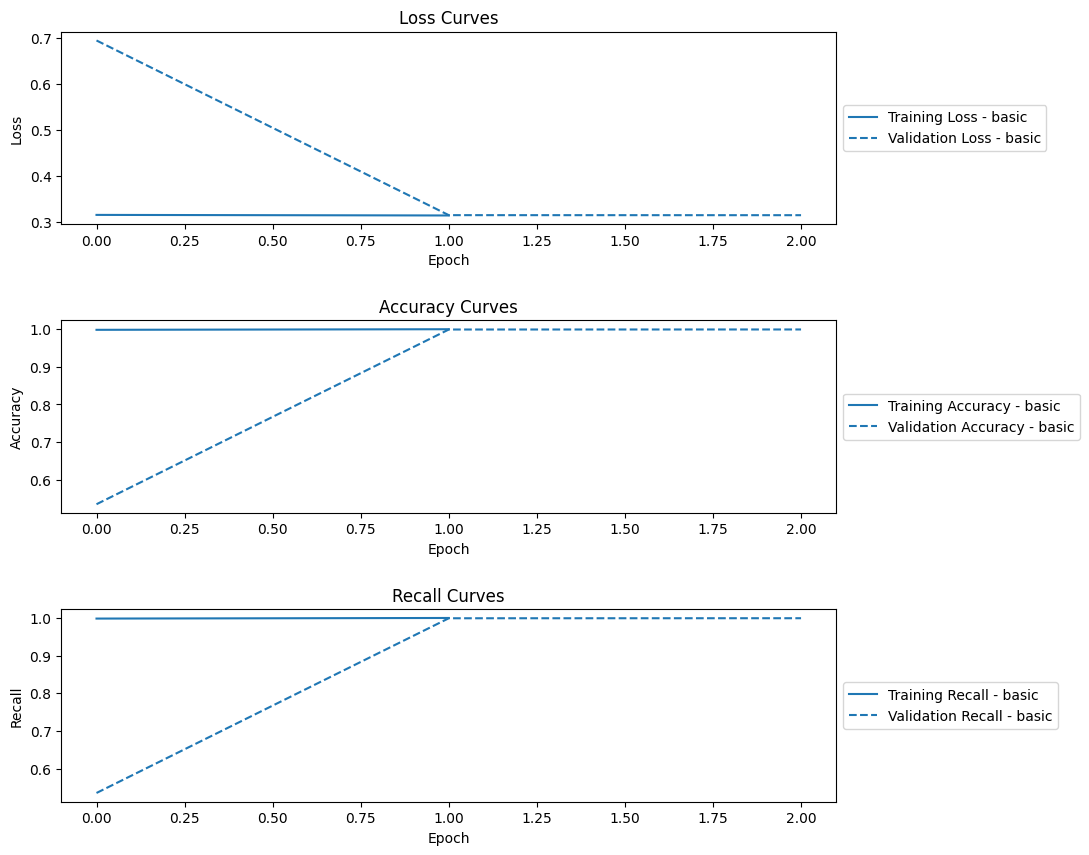

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=[10, 10])
fig.subplots_adjust(hspace=0.5)
for _, (model, metrics) in enumerate(results_metrics.items()):
    #ls = {'basic': 'solid', 'resnet56': 'dashed', 'resnet50': 'dotted'}[model]
    color = {'basic': 'C0', 'resnet56': 'C1', 'resnet50': 'C2'}[model]
    ax[0].plot(metrics['train_loss'], color=color, label=f'Training Loss - {model}')
    ax[0].plot(metrics['val_loss'], color=color, ls='dashed', label=f'Validation Loss - {model}')

    ax[1].plot(metrics['train_accuracy'], color=color, label=f'Training Accuracy - {model}')
    ax[1].plot(metrics['val_accuracy'], color=color, ls='dashed', label=f'Validation Accuracy - {model}')

    ax[2].plot(metrics['train_recall'], color=color, label=f'Training Recall - {model}')
    ax[2].plot(metrics['val_recall'], color=color, ls='dashed', label=f'Validation Recall - {model}')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curves')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))  # optionally show legend

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curves')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))  # optionally show legend

ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Recall')
ax[2].set_title('Recall Curves')
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('./loss_accuracy.png', dpi=300)
plt.show()       # display the plot

In [ ]:
len(results_predictions['basic']), results_predictions['basic'].keys(), len(results_predictions['basic']['probabilities'])

(4,
 dict_keys(['probabilities', 'predictions', 'true_labels', 'confusion_matrix']),
 34220)

In [ ]:
results_predictions['basic']['predictions'][:10]

[array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32),
 array([1., 0.], dtype=float32)]

In [ ]:
np.array(results_predictions['basic']['probabilities'][:3])

array([[1.0000000e+00, 2.2927043e-13],
       [1.0000000e+00, 2.1476144e-13],
       [1.0000000e+00, 2.1502417e-13]], dtype=float32)

0


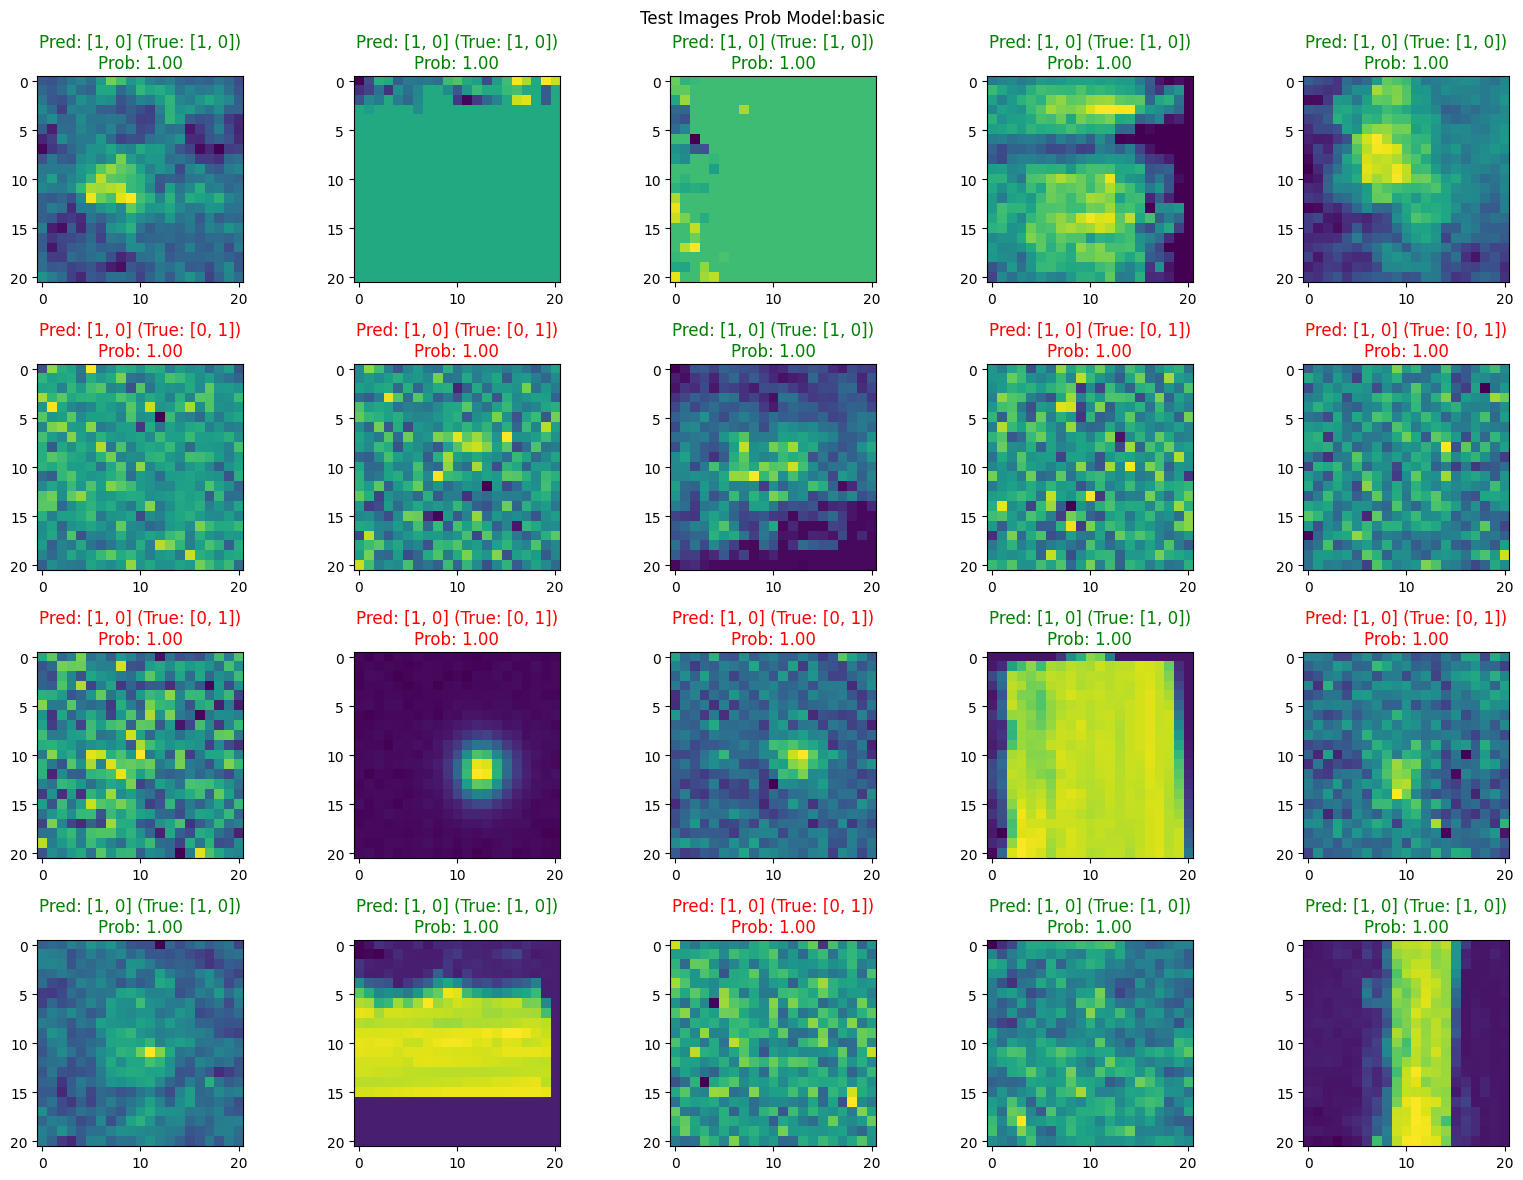

In [ ]:
n = 20
for batch in test_dataloader:
    x, y = batch
    test_images = x[:n,...]
    true_labels = y[:n,...]
    break

num_cols = 5
num_rows = (n + num_cols - 1) // num_cols  # Compute rows dynamically

for model in models:
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=[16, 12])
    fig.suptitle(f'Test Images Prob Model:{model}')
    ax = ax.flatten()

    # Retrieve the probabilities for the current model
    probabilities = np.array(results_predictions[model]['probabilities'][:n])
    predictions = (probabilities >= 0.5).astype(int)  # Binarize predictions
    print(np.argmax(probabilities[0]))

    #print(probabilities)

    # Remove unused axes
    for tmp_ax in ax[len(test_images[:n]):]:
        tmp_ax.set_axis_off()

    for i, image in enumerate(test_images[:n]):
        is_correct  = np.array_equal(predictions[i], true_labels[i].cpu().numpy())
        title_color = "green" if is_correct else "red"

        argmax = np.argmax(probabilities[i])

        ax[i].imshow(image[0], cmap="viridis")  # Use channel 0 for grayscale
        ax[i].set_title(
            f"Pred: {predictions[i].tolist()} (True: {[int(x) for x in true_labels[i].tolist()]})\nProb: {probabilities[i][argmax]:.2f}",
            #f"Pred: {predictions[i].tolist()} (True: {[int(x) for x in true_labels[i].tolist()]})\nProb: {probabilities[i,1]:.2f}",
            color=title_color,
        )
        ax[i].set_axis_on()

    plt.tight_layout()
    #plt.savefig(f'./test_images_prob_{model}.png', dpi=300)  # Use channel 0 for grayscale
    plt.show()

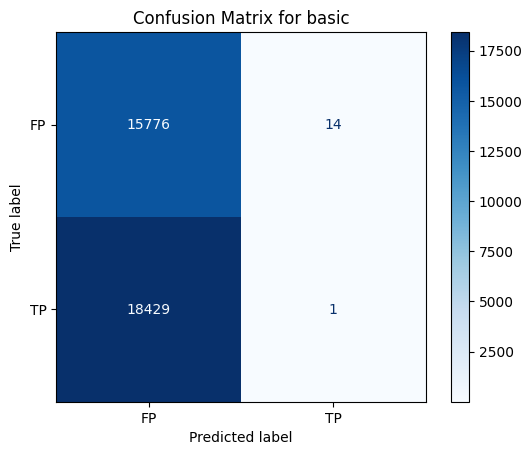

In [ ]:
# Optionally, plot the confusion matrix
for model in models:
    cm = results_predictions[model]['confusion_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FP", "TP"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model}")
    #plt.savefig(f'./confusion_matrix_{model}.png', dpi=300)
    plt.show()

below 1sigma or 2sigma

# Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

In [ ]:
def simple_model(input_shape=(21,21,1), n_classes: int = 2):
    model = tf.keras.models.Sequential(name='simple')
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_1'))
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))
    return(model)

In [ ]:
simple_cnn.summary()

In [ ]:
simple_cnn = simple_model(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.05, nesterov=True)
simple_cnn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs = 20
simple_model_history = simple_cnn.fit(train_data, train_class, epochs=n_epochs, batch_size=512, verbose=1, validation_data=(val_data, val_class), shuffle=True)

In [ ]:
model_history = simple_model_history
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.figure()
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Keras_Loss.png')
plt.figure()
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.savefig('figures/ResNet50_LC.png')